# Lets do ranking loss 

Given x0 and x1 two hidden states produced with differen't dropout states. One has a higher probability of deception.

Lets try and use ranking loss to predict which one.

see https://pytorch.org/docs/stable/generated/torch.nn.MarginRankingLoss.html#torch.nn.MarginRankingLoss


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [1]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path

import transformers


import lightning.pytorch as pl
# from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

transformers.__version__

'4.30.1'

In [2]:
from datasets import load_from_disk, concatenate_datasets
fs = [
    # "./.ds/HuggingFaceH4starchat_beta-None-N_4000-ns_3-mc_0.2-8bf3e5",
    # './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e',
    # './.ds/HuggingFaceH4starchat_beta-None-N_600-ns_3-mc_0.2-f0d838',
    
    # './.ds/HuggingFaceH4starchat_beta-None-N_4000-ns_3-mc_0.2-0392de',
    './.ds/HuggingFaceH4starchat_beta-None-N_6000-ns_3-mc_True-dc99f8',
    # './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_True-a50b5f'
]

# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds = concatenate_datasets([load_from_disk(f) for f in fs])
ds

Dataset({
    features: ['hs1', 'ans1', 'hs2', 'ans2', 'true', 'index', 'version', 'info', 'input_truncated', 'prob_y', 'prob_n', 'text_ans', 'input_text'],
    num_rows: 12000
})

## Lightning DataModule

In [3]:
def rows_item(row):
    """
    transform a row by turning singe dim arrays into items
    """
    for k,x in row.items():
        if isinstance(x, np.ndarray) and x.ndim==0:
            row[k]=x.item()
    return row

def ds_info2df(ds):
    info = list(ds['info'])
    d = pd.DataFrame([rows_item(r) for r in info])
    return d

def ds2df(ds):
    df = ds_info2df(ds)
    df_ans = ds.select_columns(['ans1', 'ans2', 'true', 'index', 'prob_y', 'prob_n', 'version']).with_format("numpy").to_pandas()
    df = pd.concat([df, df_ans], axis=1)
    
    # derived
    df['dir_true'] = df['ans2'] - df['ans1']
    df['conf'] = (df['ans1']-df['ans2']).abs()  
    df['llm_prob'] = (df['ans1']+df['ans2'])/2
    df['llm_ans'] = df['llm_prob']>0.5
    return df

In [4]:
def make_y(ds):
    pass

df = ds2df(ds)
df.head(4)

,desired_answer,input,lie,true_answer,version,ans1,ans2,true,index,prob_y,prob_n,version,dir_true,conf,llm_prob,llm_ans
0,True,Title: Horrible and dangerous for kids!\n\nCon...,True,0,lie,0.074707,0.095276,0,0,0.073975,0.915527,lie,0.020569,0.020569,0.084991,False
1,False,Title: Great television.\n\nContent: I found m...,True,1,lie,0.489990,0.544434,1,1,0.484619,0.503906,lie,0.054443,0.054443,0.517212,True
2,True,Title: Not good\n\nContent: I luv Johanna Lind...,True,0,lie,0.018829,0.028839,0,2,0.018768,0.977539,lie,0.010010,0.010010,0.023834,False
3,False,Title: unfinished business\n\nContent: Once ag...,True,1,lie,0.594238,0.571289,1,3,0.579590,0.395264,lie,-0.022949,0.022949,0.582764,True


What are we detecting? If the right example of the pair is more deceptive.

Now it's only deceptive if
- ~~it was asked to lie (in half the examples)~~ actually this might not matter
- ~~it knows the truth (97% of the time is can answer correctly if simply asked)~~ this is so common we can ignore?
- it gave the wrong answer (around 10% of the time)( it's hard to get these models to lie by encouragement rather than instruction)


In [5]:
def bool2switch(x):
    """[0,1]->[-1,1]"""
    return x*2-1

def switch2bool(x):
    """[-1,1]->[0,1]"""
    return (x+1)/2

assert switch2bool(-1)==0
assert switch2bool(1)==1
assert bool2switch(1)==1
assert bool2switch(0)==-1


def make_y(df):
    # label: is ans2 more true than ans1
    # so we ask does ans2 have greater probabiliy on "positive" than ans1
    # then, when the right answer is negative we swap the sign
    true_switch_sign = df.true_answer*2-1
    distance = (df.ans2-df.ans1) * true_switch_sign
    y = bool2switch(distance>0)
    return distance, y

In [6]:


class imdbHSDataModule(pl.LightningDataModule):

    def __init__(self,
                 ds,
                 batch_size=32,
                ):
        super().__init__()
        self.save_hyperparameters(ignore=["ds"])
        self.ds = ds

    def setup(self, stage: str):
        h = self.hparams
        
        # extract data set into N-Dim tensors and 1-d dataframe
        self.ds_hs = (
            self.ds.select_columns(['hs1', 'hs2'])
            .with_format("numpy")
        )
        self.df = ds2df(ds)
        
        y_cls, _ = make_y(self.df)
        
        self.y = y_cls.values
        self.df['y'] = y_cls
        print('y')
        
        b = len(self.ds_hs)
        self.hs1 = self.ds_hs['hs1'].reshape((b, -1))#.numpy()
        self.hs2 = self.ds_hs['hs2'].reshape((b, -1))#.numpy()        
        self.ans1 = self.df['ans1'].values
        self.ans2 = self.df['ans2'].values

        # let's create a simple 50/50 train split (the data is already randomized)
        n = len(self.y)
        
        self.val_split = vs = int(n * 0.5)
        self.test_split = ts = int(n * 0.75)
        hs1_train, hs2_train, y_train = self.hs1[:vs], self.hs2[:vs], self.y[:vs]
        hs1_val, hs2_val, y_val = self.hs1[vs:ts], self.hs2[vs:ts], self.y[vs:ts]
        hs1_test, hs2_test, y_test = self.hs1[ts:],self. hs2[ts:], self.y[ts:]
        
        
        to_ds = lambda x0, x1, y: TensorDataset(torch.from_numpy(x0).float(),
                                      torch.from_numpy(x1).float(),
                                    #   F.one_hot(torch.from_numpy(y)).float()
                                      torch.from_numpy(y).float()
                                      )

        self.ds_train = to_ds(hs1_train, hs2_train, y_train)

        self.ds_val = to_ds(hs1_val, hs2_val, y_val)

        self.ds_test = to_ds(hs1_test, hs2_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.ds_train,
                          batch_size=self.hparams.batch_size,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.hparams.batch_size)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.hparams.batch_size)


In [7]:
batch_size = 128
# test and cache
dm = imdbHSDataModule(ds, batch_size=batch_size)
dm.setup('train')

dl_val = dm.val_dataloader()
dl_train = dm.train_dataloader()
b = next(iter(dl_train))
b

y


[tensor([[-8.4595e-02,  5.6229e-03, -5.5237e-02,  ..., -6.1484e+00,
           2.3359e+00,  3.1348e+00],
         [-8.8074e-02,  3.8513e-02, -1.6235e-02,  ..., -5.4453e+00,
          -1.6572e+00,  1.6572e+00],
         [-1.4600e-01,  3.3569e-02, -1.9516e-02,  ..., -2.2812e+00,
           5.5625e+00,  2.7148e+00],
         ...,
         [-1.4514e-01,  2.1744e-03, -5.0598e-02,  ..., -4.5586e+00,
           8.7207e-01,  1.0420e+00],
         [-1.0632e-01,  1.3069e-02, -5.4932e-02,  ..., -1.9531e+00,
          -2.9766e+00,  3.8281e+00],
         [-2.2644e-01, -1.1108e-02, -6.9824e-02,  ..., -4.0547e+00,
           5.1221e-01,  5.7500e+00]]),
 tensor([[-5.1331e-02, -5.7220e-04, -6.8176e-02,  ..., -5.8906e+00,
           4.1367e+00,  6.3359e+00],
         [-1.5283e-01,  2.9160e-02, -3.0304e-02,  ..., -5.1016e+00,
          -2.0469e+00,  4.0352e+00],
         [-4.6722e-02,  4.6295e-02, -5.4138e-02,  ..., -2.6172e+00,
           1.2725e+00,  6.2617e+00],
         ...,
         [-1.6187e-01,  4

In [8]:
# dm.ds_hs['hs1'].

In [9]:

hss1 = dm.hs1
hss2 = dm.hs2
ans_1 = dm.ans1
ans_2 = dm.ans2
y = dm.y
print('y_balance', y.mean())
df = dm.df
df
dm.y

y_balance 0.0006852246026198069


array([-0.02056885,  0.05444336, -0.01000977, ..., -0.02539062,
        0.00386047, -0.01513672])

# Data prep

We do two inferences on the same inputs. Since we have dropout enabled, even during inference, we get two slightly different hidden states `hs1` and `hs2`, and two slightly different probabilities for our yes and no output tokens `p1` `p2`. We also have the true answer `t`

So there are a few ways we can set up the problem. 

We can vary x:
- `model(hs1)-model(hs2)=y`
- `model(hs1-hs2)==y`

And we can try differen't y's:
- direction with a ranked loss. This could be unsupervised.
- magnitude with a regression loss
- vector (direction and magnitude) with a regression loss

# LightningModel

In [10]:
class MLPProbe(nn.Module):
    def __init__(self, c_in, depth=0, hs=16, dropout=0):
        super().__init__()

        layers = [
            nn.BatchNorm1d(c_in),  # this will normalise the inputs
            nn.Dropout1d(dropout),            
            nn.Linear(c_in, hs),
            nn.Dropout1d(dropout),
        ]
        for _ in range(depth):
            layers += [
                nn.Linear(hs, hs),
                nn.ReLU(),
                nn.BatchNorm1d(hs),
                nn.Dropout1d(dropout),
            ]
        layers += [nn.Linear(hs, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [11]:
from pytorch_optimizer import Ranger21
import torchmetrics
# from focal_loss.focal_loss import FocalLoss

from torchmetrics import Metric, MetricCollection, Accuracy, AUROC
    
class CSS(pl.LightningModule):
    def __init__(self, c_in, total_steps, depth=1, hs=16, lr=4e-3, weight_decay=1.e-9, dropout=0.0):
        super().__init__()
        self.probe = MLPProbe(c_in, depth=depth, dropout=dropout, hs=hs)
        self.save_hyperparameters()
        
        
        # self.register_buffer('class_weights', class_weights.cuda())
        self.loss_fn = nn.SmoothL1Loss()
        
        # metrics for each stage
        metrics_template = MetricCollection({
            'acc': Accuracy(task="binary"), 
            # 'auroc': AUROC(task="binary")
        })
        self.metrics = torch.nn.ModuleDict({
            f'metrics_{stage}': metrics_template.clone(prefix=stage+'/') for stage in ['train', 'val', 'test']
        })
        
    def forward(self, x):
        return self.probe(x).squeeze(1)
        
    def _step(self, batch, batch_idx, stage='train'):
        x0, x1, y = batch
        ypred0 = self(x0)
        ypred1 = self(x1)
        
        if stage=='pred':
            return (ypred1-ypred0).float()
            return bool2switch(ypred1>ypred0).detach().cpu().numpy()
        
        loss = self.loss_fn(ypred1-ypred0, y)
        self.log(f"{stage}/loss", loss)
        
        m = self.metrics[f'metrics_{stage}']
        m(1.0*(ypred1>ypred0), y>0)
        self.log_dict(m, on_epoch=True, on_step=False)
        return loss
    
    def training_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx)
    
    def validation_step(self, batch, batch_idx=0):
        return self._step(batch, batch_idx, stage='val')
    
    def predict_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx, stage='pred').cpu().detach()
    
    def test_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx, stage='test')
    
    def configure_optimizers(self):
        """use ranger21 from  https://github.com/kozistr/pytorch_optimizer"""
        optimizer = Ranger21(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,       
            num_iterations=self.hparams.total_steps,
        )
        return optimizer
    
    

# Run

In [12]:
# quiet please
torch.set_float32_matmul_precision('medium')

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*F-score.*")

## Prep dataloader/set

In [13]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
b = next(iter(dl_train))
b

[tensor([[-6.0760e-02,  1.8295e-02, -3.6499e-02,  ..., -5.9727e+00,
           2.0020e-02,  6.4453e+00],
         [-8.8318e-02,  2.2217e-02, -7.1899e-02,  ..., -2.4922e+00,
          -1.9604e-01,  3.9941e+00],
         [-2.9358e-02, -2.5330e-03, -2.8351e-02,  ..., -7.7695e+00,
           4.8096e-02,  3.2969e+00],
         ...,
         [-1.2842e-01, -1.1719e-02, -5.4901e-02,  ..., -6.9531e+00,
          -5.0508e+00,  3.6699e+00],
         [ 8.1177e-03,  5.0293e-02, -3.6224e-02,  ..., -4.4727e+00,
           1.9751e-01,  1.5518e+00],
         [-1.6907e-02,  0.0000e+00, -5.0568e-02,  ..., -5.1719e+00,
           7.1641e+00,  3.5527e+00]]),
 tensor([[-1.4307e-01,  3.5645e-02, -3.0106e-02,  ..., -5.6094e+00,
          -2.6016e+00,  7.2188e+00],
         [-6.5674e-02,  3.6438e-02, -5.4077e-02,  ..., -2.9082e+00,
           5.2734e-02,  3.2949e+00],
         [-4.2725e-02,  4.1595e-02, -3.4851e-02,  ..., -3.7344e+00,
          -2.3145e+00,  2.2812e+00],
         ...,
         [-7.4097e-02, -1

In [33]:
# init the model
max_epochs = 104
c_in = b[0].shape[-1]
print(b[0].shape)
net = CSS(c_in=c_in, total_steps=max_epochs*len(dl_train), depth=5, hs=62, lr=1e-3, dropout=0.1, weight_decay=1e-4)
net

torch.Size([128, 116736])


CSS(
  (probe): MLPProbe(
    (net): Sequential(
      (0): BatchNorm1d(116736, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout1d(p=0.1, inplace=False)
      (2): Linear(in_features=116736, out_features=62, bias=True)
      (3): Dropout1d(p=0.1, inplace=False)
      (4): Linear(in_features=62, out_features=62, bias=True)
      (5): ReLU()
      (6): BatchNorm1d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout1d(p=0.1, inplace=False)
      (8): Linear(in_features=62, out_features=62, bias=True)
      (9): ReLU()
      (10): BatchNorm1d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout1d(p=0.1, inplace=False)
      (12): Linear(in_features=62, out_features=62, bias=True)
      (13): ReLU()
      (14): BatchNorm1d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (15): Dropout1d(p=0.1, inplace=False)
      (16): Linear(in_features=62, out_features=62, bias

In [34]:
# # DEBUG
# with torch.no_grad():
#     b = next(iter(dl_train))
#     b2 = [bb.to(net.device) for bb in b]
#     x = torch.concatenate([b2[0], b2[1]], 1)
#     y = net(x)
# y.shape, b[2].shape

In [35]:
# # DEBUG
# trainer = pl.Trainer(fast_dev_run=2)
# trainer.fit(model=net, train_dataloaders=dl_train)

In [36]:
trainer = pl.Trainer(precision="bf16",
                     
                     gradient_clip_val=20,
                     max_epochs=max_epochs, log_every_n_steps=5)

/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/fabric/connector.py:562: UserWarning: bf16 is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [37]:
# from lightning.pytorch.tuner import Tuner

# tuner = Tuner(trainer)

# # to set to your own hparams.my_value
# lr_finder = tuner.lr_find(net, train_dataloaders=dl_train, val_dataloaders=dl_val)



# # Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()

# new_lr = lr_finder.suggestion()
# # Results can be found in
# print(new_lr)

In [38]:

trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params
-----------------------------------------
0 | probe   | MLPProbe     | 7.5 M 
1 | loss_fn | SmoothL1Loss | 0     
2 | metrics | ModuleDict   | 0     
-----------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
29.966    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=104` reached.


# Read hist

In [39]:
# import pytorch_lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
from pathlib import Path
import pandas as pd

def read_metrics_csv(metrics_file_path):
    df_hist = pd.read_csv(metrics_file_path)
    df_hist["epoch"] = df_hist["epoch"].ffill()
    df_histe = df_hist.set_index("epoch").groupby("epoch").mean()
    return df_histe
        
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
df_hist


,train/loss,step,val/loss,val/acc,train/acc
epoch,,,,,
0,0.293172,28.000000,0.136858,0.489667,0.500500
1,0.228886,73.363636,0.089171,0.509000,0.510167
2,0.135270,120.416667,0.047247,0.506667,0.520167
3,0.090689,168.181818,0.034059,0.513667,0.506667
4,0.066983,215.250000,0.028454,0.515667,0.515000
...,...,...,...,...,...
99,0.004506,4680.250000,0.009407,0.671667,0.747167
100,0.004901,4728.000000,0.009438,0.678000,0.745167
101,0.005003,4773.363636,0.009496,0.675333,0.750500


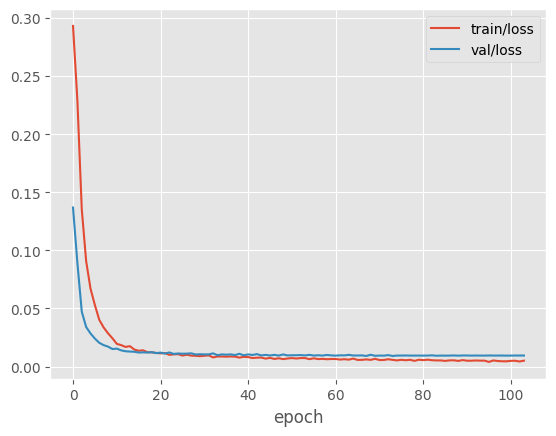

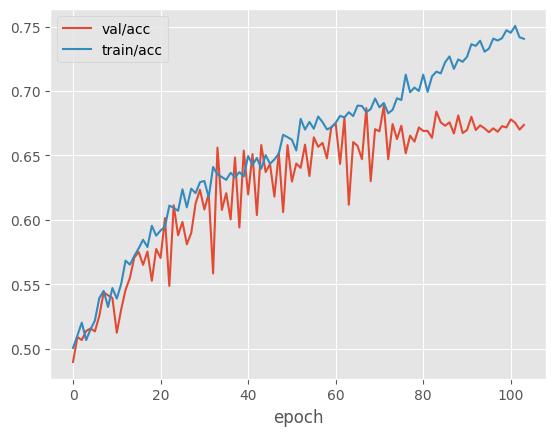

In [40]:
for key in ['loss', 'acc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()

## Predict

In [41]:
dl_test = dm.test_dataloader()
rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.8933333158493042     │     0.820111095905304     │    0.7833333611488342     │
│         test/loss         │   0.001796282478608191    │   0.009489627555012703    │   0.010054778307676315    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

In [42]:
dl_test = dm.test_dataloader()
r = trainer.predict(net, dataloaders=dl_test)
y_test_pred = np.concatenate(r)
y_test_pred.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

(3000,)

(array([1.500e+01, 9.100e+01, 3.830e+02, 1.167e+03, 9.850e+02, 2.840e+02,
        6.000e+01, 1.300e+01, 1.000e+00, 1.000e+00]),
 array([-0.14746094, -0.10957031, -0.07167969, -0.03378906,  0.00410156,
         0.04199219,  0.07988282,  0.11777344,  0.15566406,  0.19355468,
         0.23144531]),
 <BarContainer object of 10 artists>)

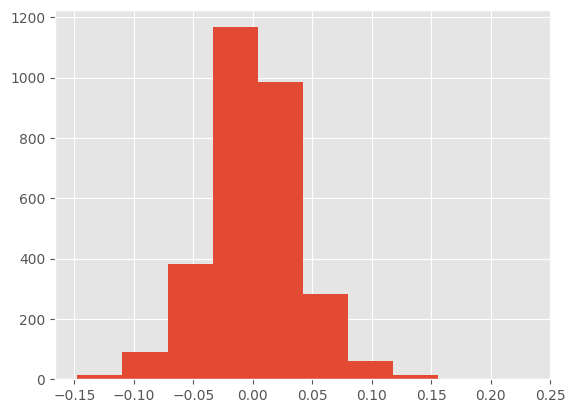

In [43]:
plt.hist(y_test_pred)

In [44]:
# y_test_pred_bool = np.clip(switch2bool(y_test_pred), 0 ,1)
# # y_bool = switch2bool(df_test['y'])
# y_test_pred_bool
# df_test['y']==switch2bool(y_true)

In [45]:
# (df_test['y'].values,switch2bool(y_true)>0.5)

In [46]:
df_test = dm.df.iloc[dm.test_split:].copy()
df_test['probe_pred'] = y_test_pred>0.5
df_test['probe_prob'] = y_test_pred
df_test['llm_prob'] = (df_test['ans1']+df_test['ans2'])/2
df_test['llm_ans'] = df_test['llm_prob']>0.5
df_test['conf'] = (df_test['ans1']-df_test['ans2']).abs()
df_test['y2'] = switch2bool(df_test['y'])>0.5

y_true = dl_test.dataset.tensors[2].numpy()
assert ((df_test['y2'].values)==(switch2bool(y_true)>0.5)).all(), 'check it all lines up'

df_test

,desired_answer,input,lie,true_answer,version,ans1,ans2,true,index,prob_y,prob_n,version,dir_true,conf,llm_prob,llm_ans,y,probe_pred,probe_prob,y2
9000,False,Title: Amazing quality!!\n\nContent: Great pro...,True,1,lie,0.702148,0.711426,1,4500,0.699219,0.296143,lie,0.009277,0.009277,0.706787,True,0.009277,False,-0.000488,True
9001,True,Title: Back to wrong product again.\n\nContent...,True,0,lie,0.150757,0.359131,0,4501,0.149414,0.840332,lie,0.208374,0.208374,0.254944,False,-0.208374,False,-0.019775,False
9002,True,Title: This book is confusing.\n\nContent: I a...,True,0,lie,0.138306,0.348389,0,4502,0.135864,0.845215,lie,0.210083,0.210083,0.243347,False,-0.210083,False,-0.037354,False
9003,True,Title: Income Taxation is anti-constitutional!...,True,0,lie,0.437256,0.384521,0,4503,0.434570,0.558105,lie,-0.052734,0.052734,0.410889,False,0.052734,False,0.010010,True
9004,True,Title: Poor production quality\n\nContent: The...,True,0,lie,0.074219,0.070984,0,4504,0.073486,0.916016,lie,-0.003235,0.003235,0.072601,False,0.003235,False,-0.004028,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,False,Title: Could be better\n\nContent: I initially...,False,0,truth,0.012321,0.014717,0,5995,0.012207,0.977539,truth,0.002396,0.002396,0.013519,False,-0.002396,False,-0.016479,False
11996,True,Title: Everyone should own this CD!\n\nContent...,False,1,truth,0.878418,0.971680,1,5996,0.876465,0.120483,truth,0.093262,0.093262,0.925049,True,0.093262,False,0.007568,True
11997,True,Title: Definatley not outsiders anymore!\n\nCo...,False,1,truth,0.898438,0.873047,1,5997,0.894043,0.100342,truth,-0.025391,0.025391,0.885742,True,-0.025391,False,0.008606,False
11998,False,"Title: a ""don't buy""\n\nContent: I had read se...",False,0,truth,0.017166,0.013306,0,5998,0.017059,0.976074,truth,-0.003860,0.003860,0.015236,False,0.003860,False,-0.003296,True


In [47]:
def get_acc_subset(df, query):
    df_s = df.query(query)
    acc = (df_s['probe_pred']==(df_s['y2']>0.5)).mean()
    print(f"acc={acc:2.2%} [{query}]")
    return acc
    
print('probe results on subsets of the data')
get_acc_subset(df_test, 'lie==True') # it was ph told to lie
get_acc_subset(df_test, 'lie==False') # it was told not to lie
get_acc_subset(df_test, 'llm_ans==true_answer') # the llm gave the true ans
get_acc_subset(df_test, 'llm_ans==desired_answer') # the llm gave the desired ans
get_acc_subset(df_test, 'lie==True & llm_ans==desired_answer') # it was told to lie, and it did lie
get_acc_subset(df_test, 'lie==True & llm_ans!=desired_answer')

probe results on subsets of the data
acc=51.00% [lie==True]
acc=51.00% [lie==False]
acc=51.45% [llm_ans==true_answer]
acc=50.78% [llm_ans==desired_answer]
acc=47.56% [lie==True & llm_ans==desired_answer]
acc=51.61% [lie==True & llm_ans!=desired_answer]


0.516078431372549

In [48]:
roc_auc = roc_auc_score(df_test['y2'], y_test_pred)

print(f"⭐PRIMARY METRIC⭐ roc_auc of direction={roc_auc:2.2%}")

⭐PRIMARY METRIC⭐ roc_auc of direction=74.18%


In [49]:
import sklearn.metrics
sklearn.metrics.mean_squared_error(df_test['y'], y_test_pred)

0.020109556612740966

In [50]:
acc_truth = (df_test['probe_pred']==(df_test['llm_ans']>0.5)).mean()
print(f"lightning model acc at predicting the models public answer (not what it's trained for): {acc_truth:2.2%}")

lightning model acc at predicting the models public answer (not what it's trained for): 54.90%


## Task results

E.g. how well does the underlying language model do on the task

It's suprisingly hard to get it to lie without telling it to (which can cause data leakage). So with this prompting setup 10-20% is good, even for an uncensored model.

In [51]:
print('Can the model lie?')
c_in = df_test.query('lie==True')
(c_in['desired_answer']==c_in['llm_ans']).mean()

Can the model lie?


0.15